## Introduction

## Step 1. Open and Study Data

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import math as mt
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as pt
import seaborn as sns
from scipy import stats as sts

In [2]:
# Read dataset
df = pd.read_csv('games.csv')

- Perform exploratory data analysis and correct missing values, normalize data, and add columns for calculations later on.

In [3]:
# Initial data preview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Initial Observations**
- Column names have inconsistent capitalization. We will format all names to lower case
- It appears there is a total of 16175 values. However, `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, and `Rating` all have null values. We will need to fill.
- `Year_of_Release` should be int64 type. `User_Score` should be float64.
- `User_Score` also contains multiple TBD options which just means a score hasn't been submitted. These should be treated similar to the null values.
- Needs a `total_sales` column for sum of all sales in each region.

**Missing Values**
- Each missing value column has different possibilities on why there are null values present.
- For `name` and `genre`, it's possible these game names just didn't get entered, or if the data was collected from a paper survey then maybe the handwriting could not be read.
- `year_of_release` might be missing values due to respondant not knowing or the API this data was pulled from was incomplete in these areas.
- `critic_score`, `user_score`, and `rating` could all be missing values due to scores and ratings not finalized yet or from incomplete API data as described above. 

## Step 2. Prepare Data

In [4]:
# Replace column names with lowercase versions
df.columns = map(str.lower, df.columns)

In [5]:
# Add total_sales column
df['total_sales'] = df['eu_sales'] + df['na_sales'] + df['jp_sales'] + df['other_sales']
# Check if total_sales column computed correctly
df.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  \
0     28.96      3.77         8.45          76.0          8      E   
1      3.58      6.81         0.77           NaN        NaN    NaN   
2     12.76      3.79         3.29          82.0        8.3      E   
3     10.93      3.28         2.95          80.0          8      E   
4      8.89     10.22         1.00           NaN        NaN    NaN   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3        32.77  
4        31.38

In [6]:
# Name and Genre columns are only missing a couple values, so we can analyze those rows specifically and see what other information is in the row
print(df[df['name'].isnull() == True])
print()
print(df[df['genre'].isnull() == True])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  total_sales  
659           0.08           NaN        NaN    NaN         2.39  
14244         0.00           NaN        NaN    NaN         0.03  

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  total_sales  
659           0.08           NaN        NaN    NaN         2.39  
14244         0.00           NaN        NaN    NaN         0.03  


In [7]:
# Check if sales amounts for the two rows are a significant enough outlier to affect analysis later
print(f'NA mean: {df['na_sales'].mean()}')
print(f'EU mean: {df['eu_sales'].mean()}')
print(f'JP mean: {df['jp_sales'].mean()}')
print(f'Other mean: {df['other_sales'].mean()}')

NA mean: 0.26337720610230336
EU mean: 0.1450595273706252
JP mean: 0.07761711037989828
Other mean: 0.047341908465450194


- Both `name` and `genre` columns have null values for the same two rows.
- The game with a large amount of sales in NA is significant enough to keep in the data. The smaller game can be removed without affecting the average much.
- The large game can be filled with "Popular Game" for `name` and `genre` can be left blank since it is a true gap in information

In [8]:
# Address TBDs in user_score
df['user_score'] = df['user_score'].replace('tbd',-1)
# Change data type to float
df['user_score'] = df['user_score'].astype('float')

# Calculate mean user_score for filling null values
score_sum = 0
score_count = 0
for x in df['user_score']:
    if x >= 0:
        score_sum += x
        score_count += 1
score_mean = score_sum/score_count
score_mean

7.1250461133070315

- `tbd` values were first replaced with a negative one as a placeholder to help filter
- Then the column's data type is changed to `float`
- Finally, we can calculate the mean value of the user scores by filtering out the negative palceholder values. Null values will automatically be excluded from calculations. This will be used later for filling null values.

In [9]:
# Remove small game row per analysis above
df.drop(index=14244,inplace=True)
# Replace name and genre per analysis above
df['name'] = df['name'].fillna('Popular Game')
df['genre'] = df['genre'].fillna('N/A')

# Calculate fill values for null data
year_median = df.groupby('name')['year_of_release'].median().median() # Group data frame by name to avoid skewing the years for duplicate games on different platforms
critic_score_median = df.groupby('name')['critic_score'].median().median() # Group data frame by name to avoid skewing the scores for duplicate games on different platforms

# Fill null values in columns
df['year_of_release'] = df['year_of_release'].fillna(year_median)
df['user_score'] = df['user_score'].fillna(score_mean).replace(-1,score_mean) # Also replacing negative 1 placeholder value for "tbd" in user_score
df['critic_score'] = df['critic_score'].fillna(critic_score_median)
df['rating'] = df['rating'].fillna('RP') # rating column already contains values "RP" for "ratings pending" that we can use for null values in rating column

# Convert data types
df['year_of_release'] = df['year_of_release'].convert_dtypes('int64')

# Check that all null values were filled and datatypes are correct
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16714 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16714 non-null  object 
 1   platform         16714 non-null  object 
 2   year_of_release  16714 non-null  Int64  
 3   genre            16714 non-null  object 
 4   na_sales         16714 non-null  float64
 5   eu_sales         16714 non-null  float64
 6   jp_sales         16714 non-null  float64
 7   other_sales      16714 non-null  float64
 8   critic_score     16714 non-null  float64
 9   user_score       16714 non-null  float64
 10  rating           16714 non-null  object 
 11  total_sales      16714 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


## Step 3. Data Analysis

In [10]:
# Check how many games were released in different years
fig = px.histogram(
    x = df['year_of_release'],
)
fig.show()

- It looks like there is a significant rise in game releases starting around 1991 and peaking around 2007/2008, then falling off and plateauing around 2012.
- Part of this is that the `year_of_release` column was filled with 2007, which was the median. However, 2008/2009 would have still been the peak so it doesn't alter the interpretation of the data too much.

In [11]:
# Check how sales vary from platform to platform
platform_sales = df.groupby('platform')['total_sales'].sum()
# Look at top 20 selling platforms to use in building distribution and store them in variable
print(platform_sales.sort_values(ascending=False).head(10)) 
top_10_platforms = platform_sales.sort_values(ascending=False).head(10).index
# Look at bottom 20 selling platforms to use in building distribution and store them in variable
print(platform_sales.sort_values(ascending=False).tail(10))
bottom_10_platforms = platform_sales.sort_values(ascending=False).tail(10).index
# Create filtered dataframes for the top and bottom ten platforms by sales
top_10 = df[df['platform'].isin(top_10_platforms)]
bot_10 = df[df['platform'].isin(bottom_10_platforms)]

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64
platform
SAT     33.59
GEN     30.74
DC      15.95
SCD      1.86
NG       1.44
WS       1.42
TG16     0.16
3DO      0.10
GG       0.04
PCFX     0.03
Name: total_sales, dtype: float64


In [12]:
# Create price distribution using top 10
fig = px.histogram(top_10.sort_values(by='platform'), color='platform',x='year_of_release',y='total_sales', range_x=(1994,2016),
                   color_discrete_map={'Wii':'rgb(218, 247, 166)','DS':'rgb(255, 195, 0)','X360':'rgb(255, 87, 51)','PS3':'rgb(199, 0, 57)','PS2':'rgb(144, 12, 63)','GBA':'rgb(88, 24, 69)','PS4':'rgb(218, 159, 24)','PS':'rgb(42, 24, 218)','PC':'rgb(218, 24, 89)','PSP':'rgb(209, 24, 218)'},
                   labels={
                    'total_sales':'Total Sales ($)',
                    'year_of_release':'Year of Release'
                   }
                   )
fig.update_layout(title='Top 10 Platform Sales by Year',plot_bgcolor='tan', bargap = 0.1)
fig.show()

- One thing to note is that total sales for different platforms. If you select only the PlayStation platforms (`PS`, `PS2`, `PS3`, `PS4`), you can see how when the sales of a new version of the platform begin, there is a very sharp decline in sales of the previous version (i.e. PS2 sales begin means PS sales decline). It seems like it generally takes **5-7 years** for a new platform to release and then another **3-5 years** for the old platform to fade away.
    - Based on this we can probably eliminate data from 2005 and older since 2006 marks the launch of most of the current generation of best selling platforms (`X360`, `Wii`, `PS3/PS4`)
- `PC`, while not being a majority of sales in any year, manages to consistently have sales every year. While most platforms have all of their sales concentrated in a range of years, `PC` consistently sells games for its platform.

In [13]:
# Create a new dataframe that contains only the relevant years
model_df = df[df['year_of_release'] > 2005]

# Rerun code from above to produce new histogram with only relevant years considered
# Check how sales vary from platform to platform
platform_sales = model_df.groupby('platform')['total_sales'].sum()
# Look at top 10 selling platforms to use in building distribution and store them in variable
print(platform_sales.sort_values(ascending=False).head(10)) 
top_10_platforms = platform_sales.sort_values(ascending=False).head(10).index
# Create filtered dataframes for the top and bottom ten platforms by sales
top_10 = model_df[model_df['platform'].isin(top_10_platforms)]
# Create price distribution using top 10
fig = px.histogram(top_10.sort_values(by='platform'),color='platform',x='year_of_release',y='total_sales', range_x=(2005,2017),
                   color_discrete_map={'Wii':'rgb(218, 247, 166)','DS':'rgb(255, 195, 0)','X360':'rgb(255, 87, 51)','PS3':'rgb(199, 0, 57)','PS2':'rgb(144, 12, 63)','GBA':'rgb(88, 24, 69)','PS4':'rgb(218, 159, 24)','PS':'rgb(42, 24, 218)','PC':'rgb(218, 24, 89)','PSP':'rgb(209, 24, 218)','XOne':'rgb(88, 24, 69)','3DS':'rgb(42, 24, 218)'},
                   labels={
                    'total_sales':'Total Sales ($)',
                    'year_of_release':'Year of Release'
                   }
                   )
fig.update_layout(title='Top 10 Platform Sales by Year',plot_bgcolor='tan', bargap = 0.1)
fig.update_layout(title='Top 10 Platform Sales by Year',plot_bgcolor='tan', bargap = 0.1)
fig.show()

platform
X360    963.17
PS3     939.65
Wii     907.51
DS      658.69
PS4     314.14
PS2     288.01
3DS     259.00
PSP     243.15
PC      167.18
XOne    159.32
Name: total_sales, dtype: float64


- After narrowing our year selection, we can see new platforms that have appeared in the top 10 selection: `XOne` and `3DS` have replaced `PS` and `GBA`.
- Judging by the trend of newly released platforms, we can also assume that Xbox One will continue to grow in sales as Xbox 360 falls off. `PS4` will most likely have more growth as well as it was released the same year as `XOne`. `3DS` by comparison is shrinking now that its approaching that 5-7 year range in which a new platform is predicted for release.
- `PC` also continues to show up in the top 10 of sales every year. It is always a minor contender, but the fact it is so consistent shows a possibility for a steady income stream.
- Using these insights, we can choose these platforms as our potentially profitable focuses for our ad campaigns: `XOne`, `PS4`, `PC`.

[Text(0.5, 0, 'Platform'), Text(0, 0.5, 'Total Sales in Millions($)')]

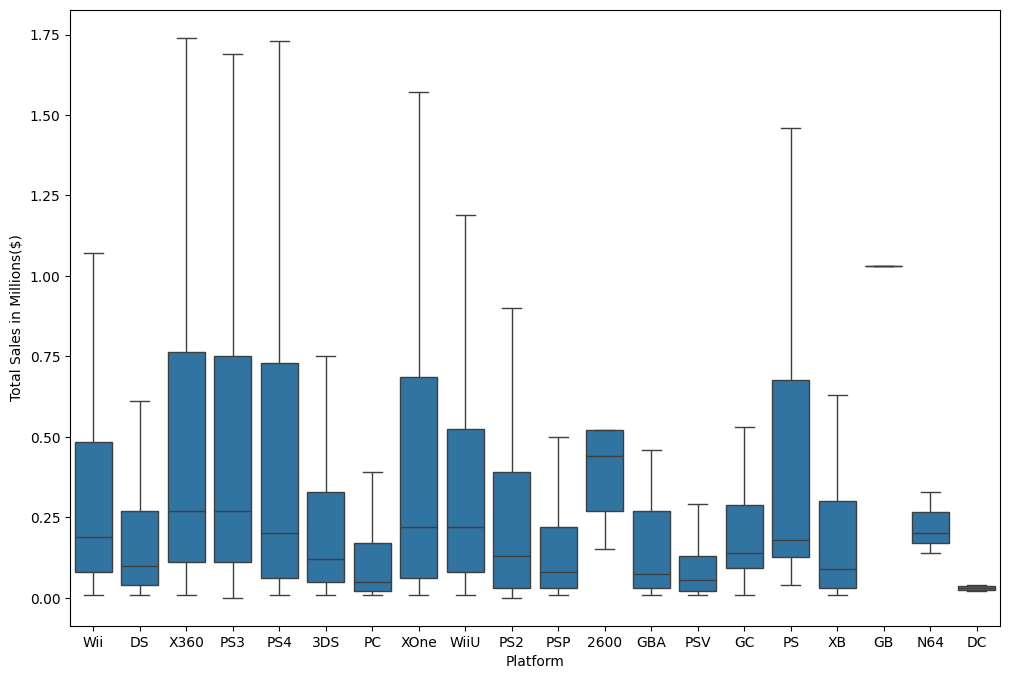

In [14]:
# Adjust size of figure for readability
pt.figure(figsize=(12,8))
# Create boxplot using seaborn and sort by platform
sns.boxplot(x='platform',y='total_sales',data=model_df, showfliers=False).set(xlabel='Platform',ylabel='Total Sales in Millions($)')

- The differences in sales for varies widely per platform, with some Xbox and Playstation platforms having a significantly higher range of total sales. In contrast, some platforms don't have any games over 0.50.
- The average sales vary much less between platform and you can see much more competitiveness between platforms here. However, its also important to remember that the Xbox and Playstation platforms have a much higher number of games made for their platforms, which leads to more games that end up selling poorly. You can see platforms like `2600` and `GB` with the opposite bias, showing a much higher rate of high selling games, and producing a higher overall average.

In [15]:
# Here we create a mask of our model dataframe to select the platform we want to analyze
mask = model_df[model_df['platform'] == 'PS3']
# Then we normalize the critic scores to match the 10 point scale user scores uses
mask['critic_score'] = mask['critic_score'].apply(lambda x: x/10)
fig = px.scatter(mask, x='total_sales',y=['user_score','critic_score'],
                color_discrete_sequence=['green','blue'],
                labels={'value':'Game Rating','total_sales':'Total Sales in Millions ($)'},
                trendline='ols', 
                title='Score versus Sales for PS3'
                )
# Edit x and y axis range for better view
fig.update_xaxes(range = [0,10])
fig.update_yaxes(dtick=1)
# Edit legend name to better display
newnames = {'user_score':'User Score', 'critic_score': 'Critic Score'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.show()

C:\Users\colin\AppData\Local\Temp\ipykernel_20008\1143326897.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# Get results of regression
results = px.get_trendline_results(fig)
# Store specific trace's result summaries for display and reading
user_results = results.iloc[0]["px_fit_results"].summary()
critic_results = results.iloc[1]["px_fit_results"].summary()
# Display results
print(user_results)
print(critic_results)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.366
Date:                Tue, 13 Aug 2024   Prob (F-statistic):            0.00388
Time:                        23:02:40   Log-Likelihood:                -2127.5
No. Observations:                1331   AIC:                             4259.
Df Residuals:                    1329   BIC:                             4269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8143      0.037    185.126      0.0

**Score versus Sales Results for PS3**
- From the regression results for `user_results` and `critic_results`, we can see that `critic_score` scale more with `total_sales` than `user_score` does. This means that critic scores rise with with the total sales of a game more often than User Scores do. This could be due to critic scores containing biases based on a game's popularity, while user scores generally depend on a specific players point of view only.

In [17]:
# Create distribution for total sales of games by game genre
fig = px.histogram(model_df, x='genre',y='total_sales',
                    color_discrete_sequence=['tan'],
                    title='Total Sales by Genre',
                    labels={'total_sales':'Total Sales in Millions ($)','genre':'Genre'}
                    )
fig.show()

**Sales by Genre Conclusions**
- It looks like the most profitable genres are `Action`, `Sports`, and `Shooter`. The least profitable genres are `Strategy`, `Puzzle`, and `Adventure`.
- In general: It looks like high profitability stems from games that reward quick pace and a lot of movement, while the less profitable games are more thought-provoking and exploration/revelation based.
    - This makes sense as the quicker based games tend to have a more instant gratification, which leads to longer engagement which in turn leads to higher recommendations.

## Step 4. Create User Profiles for Regions

### Create NA User Profile

In [18]:
# Determine top five platforms in NA
na_platform_sales = model_df.groupby('platform')['na_sales'].sum()
na_top_5 = na_platform_sales.sort_values(ascending=False).head(5).index
# Create a histogram to show the distribution of each platforms total sales by region
fig = px.histogram(model_df[model_df['platform'].isin(na_top_5)], x='platform', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','platform':'Game Platform'}, 
                    title='Market Variation for NA Top 5 Platforms',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='tan')  
fig.show()


**Conclusions**
- For North America's top 5 platforms, North America always has the higher percentage of the market share, while Japan has the lowest.
    - However, Japan's influence significantly increased when looking at `DS` platform sales.
- We can also see a closer competition between NA and EU on the `PS3` platform. This could mean ads for Playstation platforms can be pushed more in Europe.

In [19]:
# Determine top five genres in NA
na_genre_sales = model_df.groupby('genre')['na_sales'].sum()
na_top_5_genre = na_genre_sales.sort_values(ascending=False).head(5).index
# Create a histogram to show the distribution of each genre's total sales by region
fig = px.histogram(model_df[model_df['genre'].isin(na_top_5_genre)], x='genre', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','genre':'Game Genre'}, 
                    title='Market Variation for NA Top 5 Genres',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='silver')     
fig.show()

**Conclusions**
- For North America's top 5 genres, North America retains the largest percentage of the market share for each genre, with Japan *usually* coming in last.
    - For `Role-Playing` games, Japan surpasses Europe in sales. This could mean ad campaigns for the Role Playing genre could be prioritized in Japan.
- `Action` games seem to be popular among all regions, while `Shooter` and `Sports` games tend to be more prominent in NA and EU.

### Create EU User Profile

In [20]:
# Determine top five platforms in EU
eu_platform_sales = model_df.groupby('platform')['eu_sales'].sum()
eu_top_5 = eu_platform_sales.sort_values(ascending=False).head(5).index
# Create a histogram to show the distribution of each platforms total sales by region
fig = px.histogram(model_df[model_df['platform'].isin(eu_top_5)], x='platform', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','platform':'Game Platform'}, 
                    title='Market Variation for EU Top 5 Platforms',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='tan')                  
fig.show()

**Conclusions**
- For Europe's top 5 platforms, we can draw the same conclusions as above about NA's top 5 platforms.
    - The one exception being that `PS4` made it on Europe's top 5 list and is one of the only times Europe surpasses North America in market shares. This reinforces the earlier conclusion that Playstation ad campaigns will be a strong choice for Europe.

In [21]:
# Determine top five genres in EU
eu_genre_sales = model_df.groupby('genre')['eu_sales'].sum()
eu_top_5_genre = eu_genre_sales.sort_values(ascending=False).head(5).index
# Create a histogram to show the distribution of each genre's total sales by region
fig = px.histogram(model_df[model_df['genre'].isin(eu_top_5_genre)], x='genre', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','genre':'Game Genre'}, 
                    title='Market Variation for EU Top 5 Genres',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='silver')
fig.show()

**Conclusions**
- For Europe's top 5 genres, North America retains the largest percentage of the market share for each genre.
    - For `Racing` games, Europe has a higher market percentage than usual. This highlights a trend towards Racing games in Europe.

### Create JP User Profile

In [22]:
# Determine top five platforms in JP
jp_platform_sales = model_df.groupby('platform')['jp_sales'].sum()
jp_top_5 = jp_platform_sales.sort_values(ascending=False).head(5).index
# Create a histogram to show the distribution of each platforms total sales by region
fig = px.histogram(model_df[model_df['platform'].isin(jp_top_5)], x='platform', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','platform':'Game Platform'}, 
                    title='Market Variation for JP Top 5 Platforms',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='tan')                  
fig.show()

**Conclusions**
- For Japan's top 5 platforms, we notice a significant lack of Xbox platforms on the top 5 list.
- Another trend is that 3 out of 5 of Japan's top 5 platforms are Nintendo platforms, while the other 2 are Sony.
    - This highlights a strong trend towards Japanese-based companies in Japan, which is useful to know for future ad campaigns.

In [23]:
# Determine top five genres in JP
jp_genre_sales = model_df.groupby('genre')['jp_sales'].sum()
jp_top_5_genre = jp_genre_sales.sort_values(ascending=False).head(5).index
# Create a histogram to show the distribution of each genre's total sales by region
fig = px.histogram(model_df[model_df['genre'].isin(jp_top_5_genre)], x='genre', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','genre':'Game Genre'}, 
                    title='Market Variation for JP Top 5 Genres',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='silver')
fig.show()

**Conclusions**
- For Japan's top 5 genres, we again see proof that `Role-Playing` games sell better in Japan that other regions.

### All Regions

In [24]:
# Create a histogram to show the distribution of each ESRB rating's total sales by region
fig = px.histogram(model_df, x='rating', y=['na_sales','eu_sales','jp_sales'], labels={'value':'Total Sales in Millions ($)','genre':'Game Genre'}, 
                    title='Market Variation by ESRB Rating',
                    color_discrete_map={'na_sales':'blue','eu_sales':'green','jp_sales':'red'}
                    )
# Edit legend name to better display
newnames = {'na_sales':'North America', 'eu_sales': 'Europe', 'jp_sales':'Japan'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(plot_bgcolor='white')     
fig.show()

**Conclusions**
- `EC`, or Early Childhood, rated games only have sales data in North America so this rating may be region specific.
- `M` for Mature rated games sell worse in Japan than other ratings do, while games that are `RP` for Rating Pending sell better in Japan.
    - `E10+` games also don't sell very well in Japan, meaning the focus for Japan's games should be `E` for everyone games and `T` for teen.
- North America and Europe have similar market shares for each rating.

## Step 5. Hypothesis Testing

In [29]:
# Test hypothesis that average user ratings of the Xbox One and PC platforms are the same
alpha = 0.05
results = sts.ttest_ind(model_df[model_df['platform'] == 'XOne']['user_score'], model_df[model_df['platform'] == 'PC']['user_score'])
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('We reject the hypothesis that average user ratings between Xbox one and PC are the same.')
else:
    print('We can not reject null hypothesis')

p-value: 0.028755808537930253
We reject the hypothesis that average user ratings between Xbox one and PC are the same.


**Conclusions**
- It turns out average user ratings between Xbox One and PC are not the same.

In [30]:
# Test hypotheis that average user ratings for the Action and Sports genres are different.
alpha = 0.05
results = sts.ttest_ind(model_df[model_df['genre'] == 'Action']['user_score'], model_df[model_df['genre'] == 'Sports']['user_score'])
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('We reject the hypothesis that average user ratings between Action and Sports genres are the same.')
else:
    print('We can not reject null hypothesis')

p-value: 3.91351696024737e-09
We reject the hypothesis that average user ratings between Action and Sports genres are the same.


**Conclusion**
- From this test, we tested for the signicance that average user ratings for Action and Sports genres are the same. There was not enough statistical significance to support this, so we can assume the user ratings are different.

## Step 6. General Conclusion

**Final Conclusions**
- After cleaning up the data, one of the first analysis tasks was to analyze how different platforms performed through the years. The dataset originally goes back to 1994.
    - You can see a sharp rise in games being released starting in 1991 and peaking in 2007/2008.
    - We also analyzed the total sales for each platform throughout the years and found a trend where platforms would generally take **5-7 years** to release the next generation, and then another **3-5 years** for the old platform to fade away.
    - Based on this analysis, we determined we could filter out data from 2005 and earlier, since by then older platforms have faded out already and are not important when considering future advertising campaigns.

**Model Dataframe**
- We then used the new filtered dataframe as our model dataframe for future analysis.
- We reran the Top 10 Platform Sales by Year histogram and got a more focused look at which platforms were fading out and which were on the rise.
    - `Xbox One`, `Playstation 4`, and `PC` were chosen as primary platforms to focus on for advertising since Xbox One and PS4 are the newest generation and PC has consistently remained in the top 10 sales despite market changes.

**Boxplot Conclusions**
- A boxplot analyzing the total sales per platform helped highlight that there is a drastic variance in sales range between platforms.
    - Microsoft and Sony platforms (Xbox and Playstion) all have a much higher top range of sales.
    - However, average sales between platforms was less drastic and some platforms beat Microsoft and Sony in this category.
    - This highlights the fact that more games have been released for Xbox and Playstation platforms, which leads to higher competition in sales. The games that compete poorly don't sell well and end up lowering the overall average sales for the platform.
    - This means further analysis needs to be made on what game types sell well so advertising can be focused and competitive.

**User and Critic Rating**
- Analysis between user game scores and professional game scores showed that the professional critics had a higher correlation to total sales.
    - This could be because critics tend to only review games that are already popular, where as users will have more variability in the games they choose to review.

**Genre Performance**
- In general: It looks like high profitability stems from game genres that have quick paced gameplay and a lot of movement, while the less profitable games are more thought-provoking and exploration/revelation based.
    - This makes sense as the quicker based games tend to have more instant gratification, which leads to longer engagement which in turn leads to higher sales.
- The three top genres were **Action, Shooter, and Sports**.

**Region Profiles**
- Each region profile contains two charts that show the price distribution per region for the top 5 platforms and top 5 genres of the profile.
- The main takeaways from each profile were:
    - North America almost always has the largest percentage of market sales for a platform or genre. This means North America should be the primary focus for gaming ads.
    - Sony platforms tend to perform better in Europe compared to platforms' performance.
    - Action games perform well in all regions, while Shooter and Sports fall short in Japan.
    - Europe has a higher percentage of sales in Racing games.
    - Japan heavily favors Japanese-based companies for their platforms (like Nintendo and Sony) and also have a higher success with Role-Playing games.
- ESRB ratings were also analyzed to see if sales differed per region
    - `EC`, or Early Childhood, rated games only have sales data in North America so this rating may be region specific.
    - `M` for Mature rated games sell worse in Japan than other ratings do, while games that are `RP` for Rating Pending sell better in Japan.
    - `E10+` games also don't sell very well in Japan, meaning the focus for Japan's games should be `E` for everyone games and `T` for teen.
    - North America and Europe have similar market shares for each rating.

**Hypothesis Testing**
- Two hypothesis were tested. One on user scores between Xbox and PC platforms and one for user scores between Action and Sports genres.
- The main takeaways were:
    - User ratings between PC and Xbox were not statiscally similar. This means users generally rate games differently on PC than they do Xbox One. This could be due to PCs usually having higher technical specifications, which can enhance the graphics and performance of a game. This probably influences user enjoyment and in turn influences their ratings.
    - User ratings between Action and Sports genres were not statistically similar. This could be due to the much larger number of Action games compared to Sports games.